In [58]:
from tensorflow import keras
from tensorflow.keras import layers
import tensorflow as tf

In [59]:
from tensorflow.keras.layers import Conv2D, BatchNormalization, Activation, MaxPooling2D, Conv2DTranspose, concatenate, Input, Dropout

In [60]:
from tensorflow.keras.models import Model

In [61]:
import numpy as np

In [62]:
import matplotlib.pyplot as plt

In [63]:
import cv2

In [64]:
import os

In [65]:
tf.__version__

'2.6.0'

In [66]:
import build_model_1

In [67]:
data_size_y = 288

In [68]:
data_size_x = 512

In [71]:
data_path = r"D:\ML Datasets\RGB-D\Monocular\train\LR"

location_path = os.listdir(data_path)

In [72]:
inp_loc = [os.path.join(data_path, folder, 'color') for folder in location_path]
# out_loc = [os.path.join(data_path, folder, 'depth_vi') for folder in location_path]

In [73]:
images = np.concatenate([[os.path.join(inp_folder, file) for file in os.listdir(inp_folder)] for inp_folder in inp_loc])

FileNotFoundError: [WinError 3] The system cannot find the path specified: 'D:\\ML Datasets\\RGB-D\\Monocular\\train\\LR\\color\\color'

In [74]:
# results = np.concatenate([[os.path.join(out_folder, file) for file in os.listdir(out_folder)] for out_folder in out_loc])

In [75]:
images[0]

NameError: name 'images' is not defined

In [76]:
# results[0]

In [77]:
input_layer = Input((data_size_y, data_size_x, 3))
model = build_model_1.build_model2(input_layer, 16)
# model = keras.models.load_model('depth.h5')

In [78]:
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, 288, 512, 3) 0                                            
__________________________________________________________________________________________________
conv2d_24 (Conv2D)              (None, 288, 512, 64) 1792        input_2[0][0]                    
__________________________________________________________________________________________________
conv2d_25 (Conv2D)              (None, 288, 512, 64) 36928       conv2d_24[0][0]                  
__________________________________________________________________________________________________
max_pooling2d_5 (MaxPooling2D)  (None, 144, 256, 64) 0           conv2d_25[0][0]                  
____________________________________________________________________________________________

In [79]:
model.compile(loss="categorical_crossentropy", optimizer="adam", metrics=["accuracy"])

In [116]:
dataset_size = 128

shift = 128 * 1

x_test = np.empty((dataset_size, data_size_y, data_size_x, 3))
y_test = np.empty((dataset_size, data_size_y, data_size_x, 1))

In [117]:

for i in range(dataset_size):
    x_test[i] = cv2.imread(images[i+shift], cv2.IMREAD_UNCHANGED).reshape(data_size_y, data_size_x, 3)
    y_test[i] = cv2.imread(os.path.join(*(images[i+shift].split('\\')[0:7]),'depth_filled',images[i+shift].split('\\')[8][:-5] + 'depth_filled.png'),cv2.IMREAD_UNCHANGED).reshape(data_size_y, data_size_x, 1)

x_test = x_test / 255
y_test = y_test / 7500

In [38]:
plt.imshow(x_test[0])

NameError: name 'x_test' is not defined

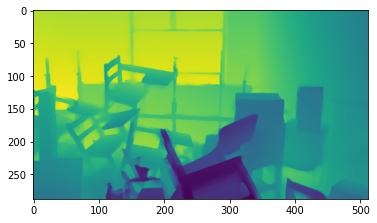

In [120]:
plt.imshow(y_test[0])

In [55]:
# model.fit(x_test, y_test, batch_size=1, epochs=10, validation_split=0.0)
# model.fit(dataset, batch_size=1, epochs=10, validation_split=0.0)

Epoch 1/10


ValueError: in user code:

    c:\users\deark\appdata\local\programs\python\python39\lib\site-packages\keras\engine\training.py:853 train_function  *
        return step_function(self, iterator)
    c:\users\deark\appdata\local\programs\python\python39\lib\site-packages\keras\engine\training.py:842 step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    c:\users\deark\appdata\local\programs\python\python39\lib\site-packages\tensorflow\python\distribute\distribute_lib.py:1286 run
        return self._extended.call_for_each_replica(fn, args=args, kwargs=kwargs)
    c:\users\deark\appdata\local\programs\python\python39\lib\site-packages\tensorflow\python\distribute\distribute_lib.py:2849 call_for_each_replica
        return self._call_for_each_replica(fn, args, kwargs)
    c:\users\deark\appdata\local\programs\python\python39\lib\site-packages\tensorflow\python\distribute\distribute_lib.py:3632 _call_for_each_replica
        return fn(*args, **kwargs)
    c:\users\deark\appdata\local\programs\python\python39\lib\site-packages\keras\engine\training.py:835 run_step  **
        outputs = model.train_step(data)
    c:\users\deark\appdata\local\programs\python\python39\lib\site-packages\keras\engine\training.py:787 train_step
        y_pred = self(x, training=True)
    c:\users\deark\appdata\local\programs\python\python39\lib\site-packages\keras\engine\base_layer.py:1037 __call__
        outputs = call_fn(inputs, *args, **kwargs)
    c:\users\deark\appdata\local\programs\python\python39\lib\site-packages\keras\engine\functional.py:414 call
        return self._run_internal_graph(
    c:\users\deark\appdata\local\programs\python\python39\lib\site-packages\keras\engine\functional.py:550 _run_internal_graph
        outputs = node.layer(*args, **kwargs)
    c:\users\deark\appdata\local\programs\python\python39\lib\site-packages\keras\engine\base_layer.py:1020 __call__
        input_spec.assert_input_compatibility(self.input_spec, inputs, self.name)
    c:\users\deark\appdata\local\programs\python\python39\lib\site-packages\keras\engine\input_spec.py:229 assert_input_compatibility
        raise ValueError('Input ' + str(input_index) + ' of layer ' +

    ValueError: Input 0 of layer conv2d is incompatible with the layer: : expected min_ndim=4, found ndim=0. Full shape received: ()


In [72]:
model.save('depth.h5')

In [76]:
# image = cv2.imread(images[0], cv2.IMREAD_GRAYSCALE)
image = cv2.imread(images[20])
# image = x_test[29]

image = image / 255

truth = cv2.imread(images[20][:54] + 'depth_vi\\' + images[20][60:-5] + 'depth_vi.png').reshape(data_size_y, data_size_x, 3)
# truth = y_test[29]

truth = truth / 255

guess = model.predict(image.reshape(-1,data_size_y, data_size_x,3))

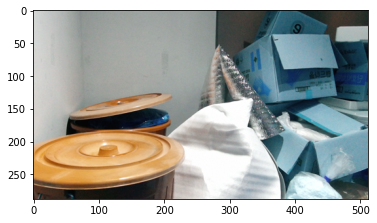

In [77]:
plt.imshow(image, cmap='gray')

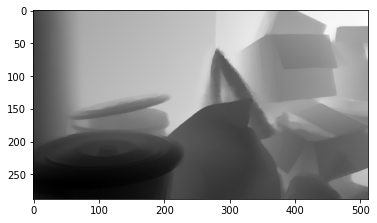

In [78]:
plt.imshow(truth, cmap='gray')

In [79]:
np.min(truth)

0.0

In [80]:
# guess[0][0][0] = .5

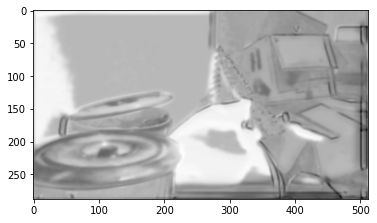

In [81]:
plt.imshow(guess.reshape(data_size_y, data_size_x), cmap='gray')

In [63]:
np.min(guess)

0.23507836

In [64]:
guess[0,0,0] = 0
guess[0,0,1] = 1

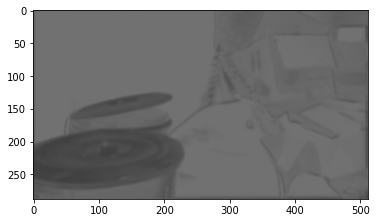

In [65]:
plt.imshow(guess.reshape(data_size_y, data_size_x), cmap='gray')